In [1]:
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np

np.random.seed(42)

def square_loss(targets, predictions):
    loss = 0
    for t, p in zip(targets, predictions):
        loss += (t - p) ** 2
    loss = loss / len(targets)
    return 0.5*loss

In [2]:
degree = 1 # degree of the target function
scaling = 2 # scaling of the data
coeffs = [0.15 + 0.15j]*degree  # coefficients of non-zero frequencies
coeff0 = 0.1  # coefficient of zero frequency

def target_function(x):
    """Generate a truncated Fourier series, where the data gets re-scaled."""
    res = coeff0
    for idx, coeff in enumerate(coeffs):
        exponent = np.complex128(scaling * (idx+1) * x * 1j)
        conj_coeff = np.conjugate(coeff)
        res += coeff * np.exp(exponent) + conj_coeff * np.exp(-exponent)
    return np.real(res)

In [3]:
print(coeffs)

[(0.15+0.15j)]


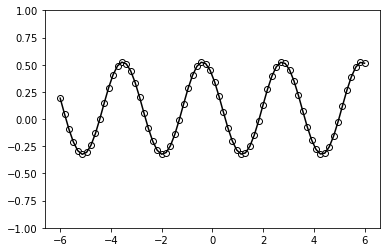

In [4]:
x = np.linspace(-6, 6, 70, requires_grad=False)
target_y = np.array([target_function(x_) for x_ in x], requires_grad=False)

plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.ylim(-1, 1)
plt.show();

In [5]:
scaling = 1

dev = qml.device('default.qubit', wires=1)

def S(x):
    """Data-encoding circuit block."""
    qml.RX(scaling * x, wires=0)

def W(theta):
    """Trainable circuit block."""
    qml.Rot(theta[0], theta[1], theta[2], wires=0)


@qml.qnode(dev)
def serial_quantum_model(weights, x):

    for theta in weights[:-1]:
        W(theta)
        S(x)

    # (L+1)'th unitary
    W(weights[-1])

    return qml.expval(qml.PauliZ(wires=0))

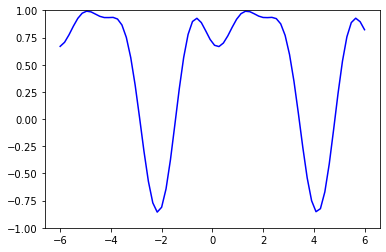

In [6]:
r = 3 # number of times the encoding gets repeated (here equal to the number of layers)
weights = 2 * np.pi * np.random.random(size=(r+1, 3), requires_grad=True) # some random initial weights

x = np.linspace(-6, 6, 70, requires_grad=False)
random_quantum_model_y = [serial_quantum_model(weights, x_) for x_ in x]

plt.plot(x, random_quantum_model_y, c='blue')
plt.ylim(-1,1)
plt.show()

In [7]:
qml.draw(serial_quantum_model)(weights, x[-1])

' 0: ──Rot(2.35, 5.97, 4.6)──RX(6)──Rot(3.76, 0.98, 0.98)──RX(6)──Rot(0.365, 5.44, 3.78)──RX(6)──Rot(4.45, 0.129, 6.09)──┤ ⟨Z⟩ \n'

In [8]:
def cost(weights, x, y):
    predictions = [serial_quantum_model(weights, x_) for x_ in x]
    return square_loss(y, predictions)

max_steps = 50
opt = qml.AdamOptimizer(0.3)
batch_size = 25
cst = [cost(weights, x, target_y)]  # initial cost

for step in range(max_steps):

    # Select batch of data
    batch_index = np.random.randint(0, len(x), (batch_size,))
    x_batch = x[batch_index]
    y_batch = target_y[batch_index]

    # Update the weights by one optimizer step
    weights, _, _ = opt.step(cost, weights, x_batch, y_batch)
    print(weights)

    # Save, and possibly print, the current cost
    c = cost(weights, x, target_y)
    cst.append(c)
    if (step + 1) % 10 == 0:
        print("Cost at step {0:3}: {1}".format(step + 1, c))

[[ 2.35330497  5.67356061  4.2992611 ]
 [ 3.46148289  1.28029378  1.28014185]
 [ 0.06495173  5.14234562  3.47691729]
 [ 4.14896322 -0.17065877  6.09412333]]
[[ 2.35330497  5.89557398  4.51514145]
 [ 3.17906441  1.5797644   1.56681228]
 [-0.19775682  4.89165252  3.18082946]
 [ 3.91351817 -0.40304225  6.09412333]]
[[ 2.35330497  6.04457117  4.73839257]
 [ 3.0243314   1.73584816  1.70465256]
 [-0.46289432  4.74059376  2.98793624]
 [ 3.64980701 -0.39920501  6.09412333]]
[[ 2.35330497  6.12562327  4.91076155]
 [ 3.01069953  1.90329835  1.73073839]
 [-0.63024775  4.64281174  2.79082437]
 [ 3.45438486 -0.4537329   6.09412333]]
[[ 2.35330497  6.19785784  5.05007857]
 [ 2.96930289  2.08814487  1.75176143]
 [-0.69030645  4.55255544  2.57923023]
 [ 3.36209241 -0.56533988  6.09412333]]
[[ 2.35330497  6.19869147  5.15723576]
 [ 2.92150897  2.27423797  1.67600975]
 [-0.64787005  4.58429908  2.39710415]
 [ 3.37690148 -0.70645487  6.09412333]]
[[ 2.35330497  6.16079533  5.24352583]
 [ 2.92127754  2.43

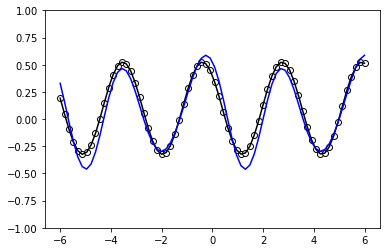

In [9]:
predictions = [serial_quantum_model(weights, x_) for x_ in x]

plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.plot(x, predictions, c='blue')
plt.ylim(-1,1)
plt.show();

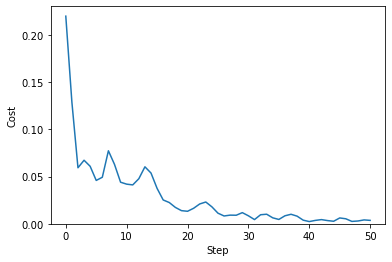

In [10]:
plt.plot(range(len(cst)), cst)
plt.ylabel("Cost")
plt.xlabel("Step")
plt.ylim(0, 0.23)
plt.show();